In [1]:
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from utils import tiffread
from utils import binning
from scipy.ndimage.filters import generic_filter

In [1]:
#use fittopo to take away a static topography for both ascending and descending mode seperately before merging
#code taken from Johan's tutorial
!python ./fittopo.py ./Ascending.h5 -d 1 1 -r 1 -q 3 -i 5 -z 10 -m 50 \
-k 1 -t 2020 -j 4326 -v lon lat t_year h_elv -s 10 -p
!python ./fittopo.py ./Descending.h5 -d 1 1 -r 1 -q 3 -i 5 -z 10 -m 50 \
-k 2 -t 2020 -j 32607 -v lon lat t_year h_elv -s 10 -p
#!python ./fittopo.py ./Descending.h5 -d 1 1 -r 1 -q 3 -i 5 -z 10 -m 100 \
#-k 2 -t 2020 -j 32607 -v lon lat t_year h_elv -s 10 -p

parameters:
('files', ['./Ascending.h5'])
('dxy', [1.0, 1.0])
('radius', [1.0])
('nreloc', [3])
('niter', [5])
('minobs', [10])
('mlim', [50])
('order', [1])
('tref', ['2020'])
('proj', ['4326'])
('vnames', ['lon', 'lat', 't_year', 'h_elv'])
('expr', [None])
('njobs', [1])
('slplim', [10.0])
('pshow', True)
running sequential code ...
Traceback (most recent call last):
  File "./fittopo.py", line 679, in <module>
    [main(f, n) for n,f in enumerate(files)]
  File "./fittopo.py", line 679, in <listcomp>
    [main(f, n) for n,f in enumerate(files)]
  File "./fittopo.py", line 357, in main
    if os.stat(ifile).st_size == 0:
FileNotFoundError: [Errno 2] No such file or directory: './Ascending.h5'


In [4]:
#merge 2 files
!python ./merge.py ./*_TOPO.h5 -o ./Alaska_AD.h5

Running sequential code ...
Calculating lenght of output from all input files ...
('reading', './Ascending_TOPO.h5')
('reading', './Descending_TOPO.h5')
Traceback (most recent call last):
  File "./merge.py", line 173, in <module>
    [merge(fi, fo, vnames, comp) for fi,fo in zip(ifile, ofile)]
  File "./merge.py", line 173, in <listcomp>
    [merge(fi, fo, vnames, comp) for fi,fo in zip(ifile, ofile)]
  File "./merge.py", line 120, in merge
    f[key][k1:k2] = f2[key][:]
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/h5py/_hl/group.py", line 264, in __getitem__
    oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5o.pyx", line 190, in h5py.h5o.open
KeyError: "Unable t

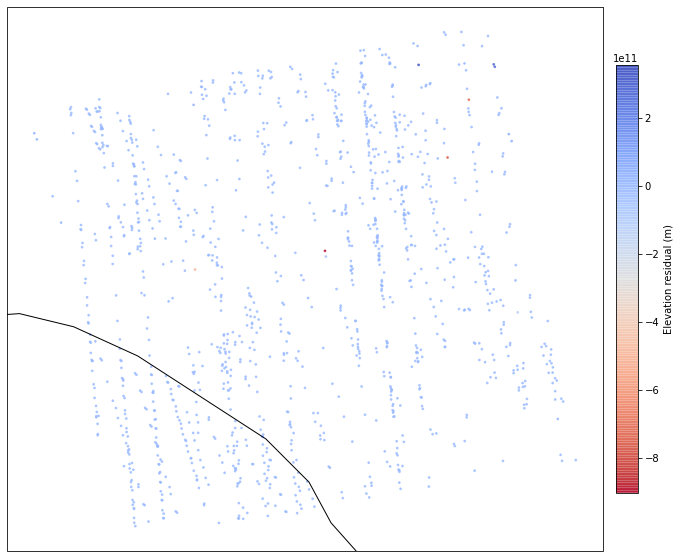

In [7]:
with h5py.File('./Alaska_AD.h5','r') as f_r:
    lat   = f_r['lat'][:]
    lon   = f_r['lon'][:]
    t_yrs = f_r['t_year'][:]
    h_res = f_r['h_res'][:]
    h_mod = f_r['h_mod'][:]
    h_org = f_r['h_elv'][:]

    
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.Stereographic(central_longitude=-150,central_latitude=70))
plt.scatter(lon[::100], lat[::100], s=3, c=h_res[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='coolwarm_r')
#plt.clim([-5,5])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation residual (m)')
ax.coastlines('50m')

In [8]:
#construct time series for this region 

with h5py.File('./Alaska_AD.h5','r') as f_r:
    lat   = f_r['lat'][:]
    lon   = f_r['lon'][:]
    t_yrs = f_r['t_year'][:]
    h_res = f_r['h_res'][:]
    h_mod = f_r['h_mod'][:]
    h_org = f_r['h_elv'][:]
x_i, y_i = transform_coord('32607', '32607', lon, lat)
z_i = spatial_filter(x_i, y_i, h_res.copy(), dx=100e3, dy=100e3, n_sigma=3)




/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/jovyan/ScienceDataGeneration/notebooks/utils.py:369: RuntimeWarning: invalid value encountered in greater
  foo = np.abs(dh) > n_sigma * np.nanstd(dh)


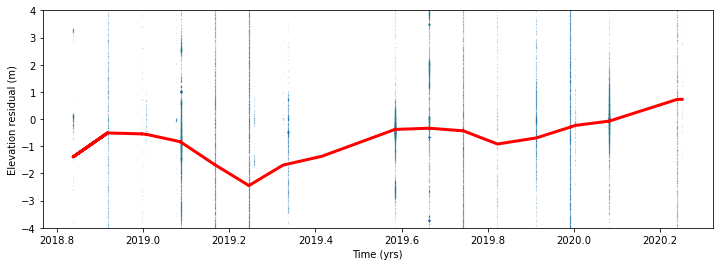

In [41]:
#binning and plot  
plt.figure(figsize=(12,4))
xb,yb = binning(t_yrs, z_i, xmin=2018.5,xmax=2020.26, dx=0.1, window=0.25,interp=True, median=True)[0:2]
plt.plot(t_new,z_i_new,'.',markersize=0.1)
plt.plot(xb, yb,'-r', linewidth=3)
plt.ylim([-4,4])
plt.ylabel('Elevation residual (m)')
plt.xlabel('Time (yrs)')
plt.savefig("topo_timeseries.png")

Text(0.5, 0, 'Time (yrs)')

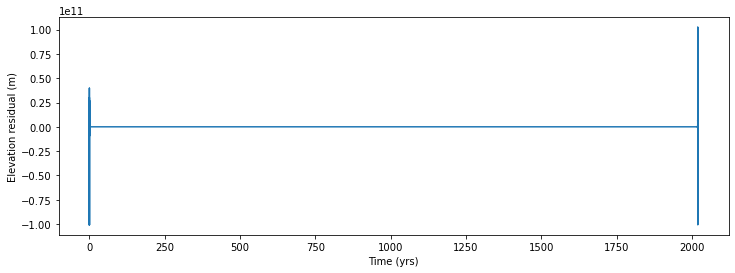

In [28]:
plt.figure(figsize=(12,4))
#xb,yb = binning(t_yrs, z_i, xmin=2018.5,xmax=2020.26, dx=0.1, window=0.25,interp=True, median=True)[0:2]
plt.plot(t_yrs,z_i)
#plt.plot(xb, yb,'-r', linewidth=3)
#plt.ylim([-4,4])
plt.ylabel('Elevation residual (m)')
plt.xlabel('Time (yrs)')